# Final Challenge Spam/Ham Classification


**In this project**, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.



## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 1
1c | 2
2 | 3
3a | 2
3b | 2
4 | 2
5 | 2
6a | 1
6b | 1
6c | 2
6d | 2
6e | 1
6f | 3
7 | 5
8 | 5
9 | 3
10 | 12
Total | 50

# Part I - Initial Analysis

In [111]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions for evaluation.

In [112]:


original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.



In [113]:
# Print the NaN value in id column
id_nan = original_training_data['id'].isnull()
print("The NaN values in id column is: ",len(id_nan[id_nan != False]))

# Print the NaN value in subject column
subject_nan = original_training_data['subject'].isnull()
print("The NaN values in subject column is: ",len(subject_nan[subject_nan != False]))

# Print the NaN value in email colunm
email_nan = original_training_data['email'].isnull()
print("The NaN values in email column is: ", len(email_nan[email_nan != False]))

# Replace the NaN with empty strings
original_training_data.loc[id_nan[id_nan != False].index, 'id'] = ''
original_training_data.loc[subject_nan[subject_nan != False].index,'subject'] = ''
original_training_data.loc[email_nan[email_nan != False].index, 'email'] = ''

# Print the NaN value in id column
id_nan = original_training_data['id'].isnull()
print("The NaN values in id column after replacement is: ",len(id_nan[id_nan != False]))

# Print the NaN value in subject column
subject_nan = original_training_data['subject'].isnull()
print("The NaN values in subject column after replacement is: ",len(subject_nan[subject_nan != False]))

# Print the NaN value in email colunm
email_nan = original_training_data['email'].isnull()
print("The NaN values in email column after replacement is: ", len(email_nan[email_nan != False]))

The NaN values in id column is:  0
The NaN values in subject column is:  4
The NaN values in email column is:  0
The NaN values in id column after replacement is:  0
The NaN values in subject column after replacement is:  0
The NaN values in email column after replacement is:  0


### Question 1b

In the cell below, print the text of the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [114]:
first_ham = original_training_data[original_training_data['spam'] == 0]['email'].head(1)
first_spam = original_training_data[original_training_data['spam'] == 1]['email'].head(1)
print(first_ham)
print(first_spam)

0    url: http://boingboing.net/#85534171\n date: n...
Name: email, dtype: object
2    <html>\n <head>\n </head>\n <body>\n <font siz...
Name: email, dtype: object


<!-- BEGIN QUESTION -->

### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->

_The ham email has readable content, while the spam email contains lots of html formats that are hard to read._

<!-- END QUESTION -->



## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. 

In [115]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [116]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    list_t = []
    for word in words:
        list_t.append(np.array([texts.str.findall(word).map(lambda x: 0 if len(x) == 0 else 1)]).T)

    first = list_t[0]
    for i in range(1,len(list_t)):
        first = np.hstack((first, list_t[i]))
    indicator_array = first
    return np.array(indicator_array)

# Test the sample
words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

Hint:
- You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [117]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column."))
display(df.melt("type"))

> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


<!-- BEGIN QUESTION -->

### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->

Text(0.5, 1.0, 'Frequency of Words in Spam/Ham Emails')

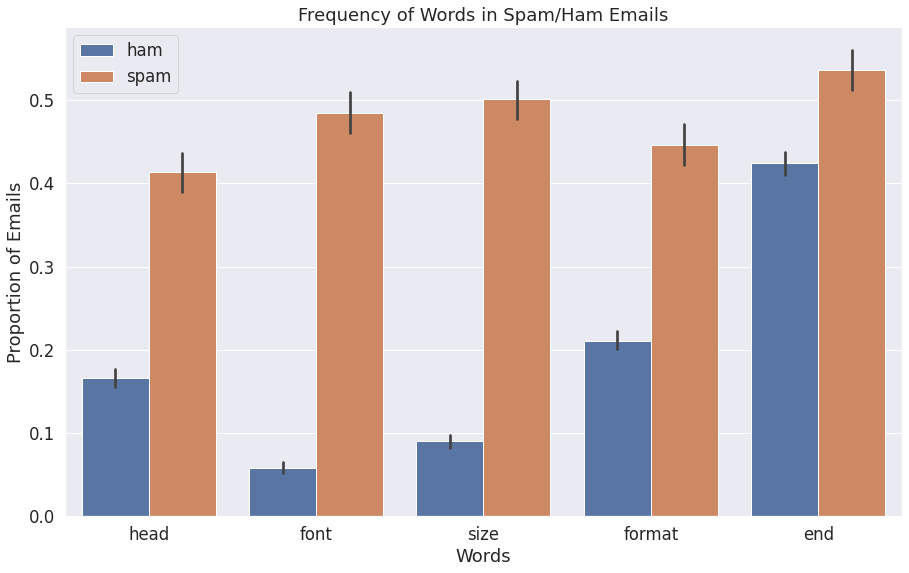

In [118]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
new_columns = pd.DataFrame(words_in_texts(['head','font', 'size', 'format', 'end'], train['email']), columns = ['head','font','size','format', 'end'])
combined = pd.concat([train, new_columns], axis = 1)
cared = combined.loc[:,['head','font', 'size', 'format', 'end', 'spam']]
melted = cared.melt('spam')
sns.set({'figure.figsize':[15,9]})
pic = sns.barplot(x = melted['variable'], y = melted['value'], hue = melted['spam'])
pic.legend(handles = pic.legend_.legendHandles,labels = ['ham', 'spam'])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.title('Frequency of Words in Spam/Ham Emails')

<!-- END QUESTION -->



When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

![training conditional densities](./images/training_conditional_densities.png "Class Conditional Densities")


<!-- BEGIN QUESTION -->

### Question 3b

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->

/home/haoquan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/haoquan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


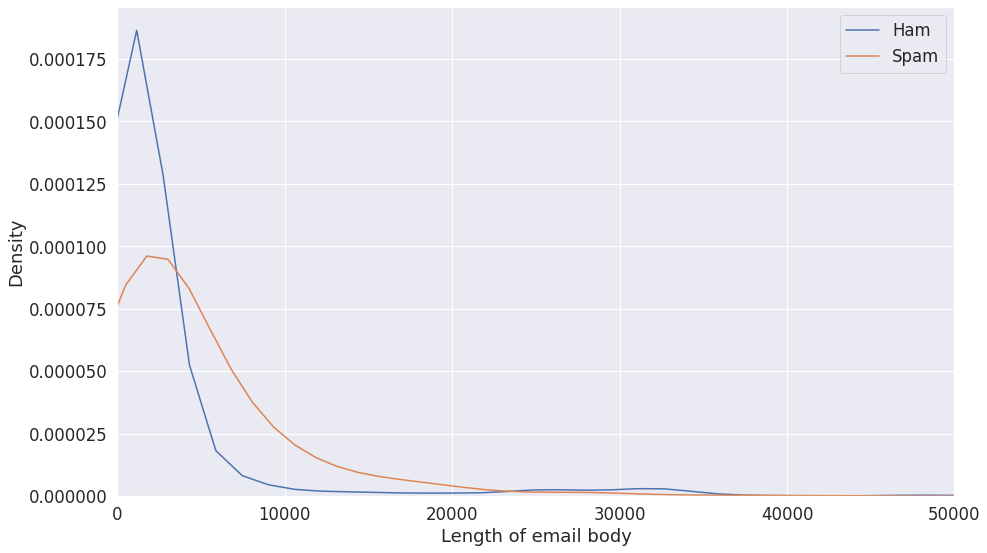

In [119]:
train['text_length'] = train['email'].map(lambda x: len(x))
spam_train = train[train['spam'] == 1]
ham_train = train[train['spam'] == 0]
sns.distplot(x = ham_train['text_length'], hist = False)
sns.distplot(x = spam_train['text_length'], hist = False)
plt.xlim([0,50000])
plt.xlabel('Length of email body')
plt.legend(['Ham','Spam'])

<!-- END QUESTION -->



# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [120]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    1
 Name: spam, dtype: int64)

### Question 5

Now that we have matrices, we can use to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [121]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 0).fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7556328443973991


## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of actually spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):


<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [122]:
# Predict 0 means that we always assume the email is ham
# TP = 0, FP = 0, FN = ?, TN = ?

zero_predictor_fp = 0
zero_predictor_fn = len(train[train['spam'] == 1])
print(zero_predictor_fp)
print(zero_predictor_fn)

0
1708


### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [123]:
# We predict all the ham correctly and all the spam wrongly
zero_predictor_acc = len(train[train['spam'] == 0]) / len(train)
zero_predictor_recall = 0

print(zero_predictor_acc)
print(zero_predictor_recall)

0.7417208528655678
0


<!-- BEGIN QUESTION -->

### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

_FP: Check whether there are ham emails mis-classified as spam emails._

_FN: Check whether there are spam emails mis-classified as ham emails._

_accuracy: Determine how many predictions are right._

_recall: Determine how many true spam emails are filtered out from spam emails_

_Since each of these values has its meaning, we need to look at all these values. And some of them may be unsuitable for evaluating the model. For example, the `accuracy` for the `zero_classifier` is almost as high as the fitted model. However, it will never filter out spam emails. By comparing the accuracies, we may find that the accuracy for the fitted model is not that good. Also, values like  recall will indicate that the `zero_classifier` is actually not a good model. In real cases, we often have to do a trade off between these values to ensure a desirable model._

<!-- END QUESTION -->

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [124]:
# Get the predicted value
train['predicted_value'] = model.predict(X_train)

# Calculate the basic quantaties
TP = len(train[(train['spam'] == 1) & (train['predicted_value'] == 1)])
TN = len(train[(train['spam'] == 0) & (train['predicted_value'] == 0)])
FP = len(train[(train['spam'] == 0) & (train['predicted_value'] == 1)])
FN = len(train[(train['spam'] == 1) & (train['predicted_value'] == 0)])
print(FN)

1508


In [125]:
logistic_predictor_precision = TP/(TP+FP)
logistic_predictor_recall = TP/(TP+FN)
logistic_predictor_far = FP/(FP+TN)

print(logistic_predictor_precision)
print(logistic_predictor_recall)
print(logistic_predictor_far)

0.6493506493506493
0.117096018735363
0.022018348623853212


<!-- BEGIN QUESTION -->

### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->

_The FP for `zero_predictor` is 0, the FP for `logistic regression classifier` is 108. We have more false positive for `logistic regression classfier`._

_The FN for `zero_predictor` is 1708, the FN for `logistic regression classifier` is 1508. We have fewer false negatice for `logistic regression classifier`_

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->

_1. The accuracy of `zero_predictor` is about 74.2%, so we see that the accuracy of `logistic regression classifier` does not improve much._

_2. The words we choose like `private` seldom show in emails, since they are not prevalent. The result is that, we can seldom find these words in emails, and thus we perform as if there is no spam emails. This leads to a poor performance comparable to the `zero_predictor`._

_3. I will prefer `logistic regression classifier`. Since `zero_predictor` actually plays no rule in filtering out the spam emails. It just regards all emails as ham emails, which is completely nonsense._

<!-- END QUESTION -->



# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **85%** accuracy on the test set. 


Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **validation data** to evaluate your model and get a better sense of how it will perform on the test set.*

---

<!-- BEGIN QUESTION -->

### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->

_1. I find better features by four different ways. We can first look at the length of the email. We can see whether this email is a reply. Or we can choose some carefully selected words. Also, we can count whether there are consecutive "?" and "!"._

_2. We expect all the methods mentioned in 1 will work. I have to mention that, we need to make the parameter of the length of uppercase letters and "?/!" to be at least 2 and 5. Otherwise the features will not work._

_3. It is surprising that there are so many "?" and "!" signs in spam emails._

<!-- END QUESTION -->



### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. Include

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->

Text(0.5, 1.0, 'Distrition of length for spam and ham emails')

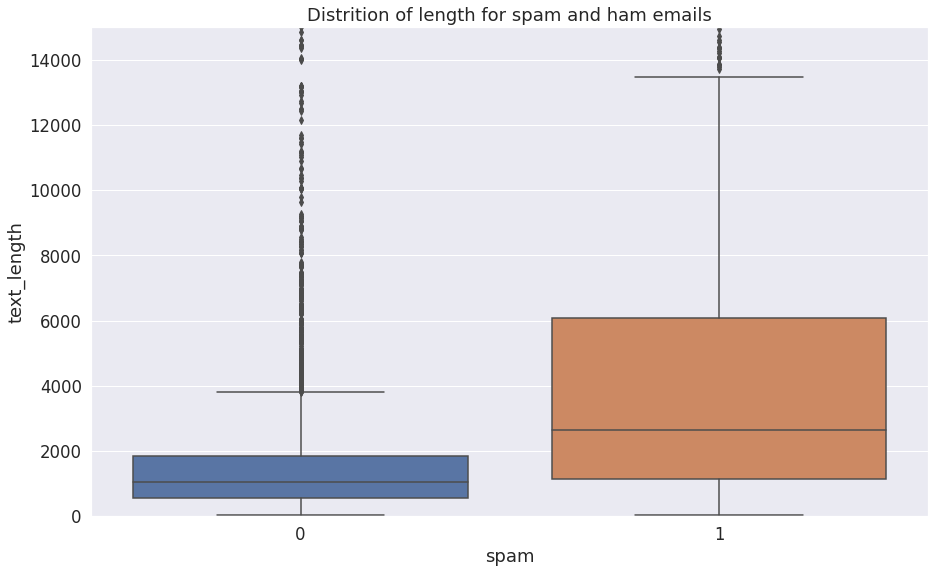

In [126]:
# Write your description (2-3 sentences) as a comment here:
# Here we try to look at whether the length of the email have relation to the spam/ham.
# We can looka at the boxplot of the lenght for spam emails and ham emails
# And we find that there is indeed a significant difference, for which we decide to use this feature

# Write the code to generate your visualization here:
pic = sns.boxplot(x = "spam", y = 'text_length', data = train)
plt.ylim([0,15000])
plt.title("Distrition of length for spam and ham emails")

##### In the following cell we explore whehter reply is related to spam

<AxesSubplot:>

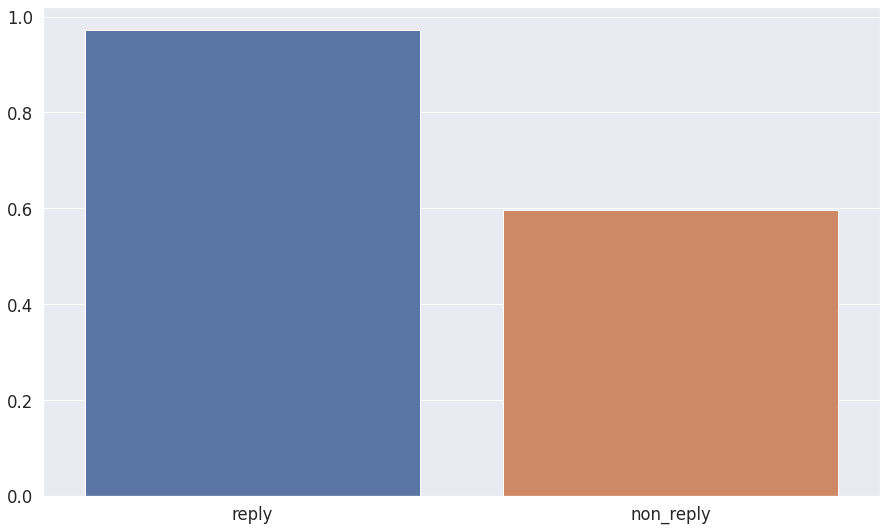

In [127]:
import re
pattern = r".*(RE:|Re:).*"
train['isReply'] = train['subject'].str.findall(pattern).map(lambda x: 0 if len(x) == 0 else 1)
replies = train[train['isReply'] == 1]
non_replies = train[train['isReply'] == 0]

reply_values = replies['spam'].value_counts()
non_reply_values = non_replies['spam'].value_counts()

p_reply_ham = reply_values[0]/sum(reply_values)
p_non_reply_ham = non_reply_values[0]/sum(non_reply_values)

sns.barplot(x = ['reply','non_reply'], y = [p_reply_ham, p_non_reply_ham])

##### In the following cell we consider the length of the email

In [128]:
train

,id,subject,email,spam,text_length,predicted_value,isReply
0,6452,Subject: Re: Ximian apt repos?\n,on 21 jul 2002 14:20:42 +1200\n mark derricutt...,0,2186,0,1
1,1488,"Subject: Re: dylsexics of the wrold, untie!\n","on thu, 12 sep 2002, tom wrote:\n \n > yep, th...",0,567,0,1
2,3693,Subject: Re: [VoID] a new low on the personals...,pity. reading that woman's ad and knowing roh...,0,285,0,1
3,156,Subject: Re: [SAtalk] OT: DNS MX Record Clarif...,"on fri, 2002-09-13 at 14:33, vernon wrote:\n >...",0,875,0,1
4,3353,Subject: 11th Convergence India 2003 exhibitio...,<html><head>\n <meta http-equiv=content-type c...,1,8285,0,0
...,...,...,...,...,...,...,...
6608,5191,Subject: Need a Lawyer?\n,this is a multi-part message in mime format.\n...,1,5472,0,0
6609,5226,"Subject: Home Loan Alert, 6.25 30 YR Fixed hzo\n","<html>\n \n <body>\n \n <font size=""2"" ptsize=...",1,6643,0,0
6610,5390,Subject: Re: Ouch... [Bebergflame]\n,"on fri, 6 sep 2002, kragen sitaker wrote:\n \n...",0,435,0,1
6611,860,Subject: Re: new bugs\n,--==_exmh_-2058972181p\n content-type: text/pl...,0,2279,0,1


(0.0, 15000.0)

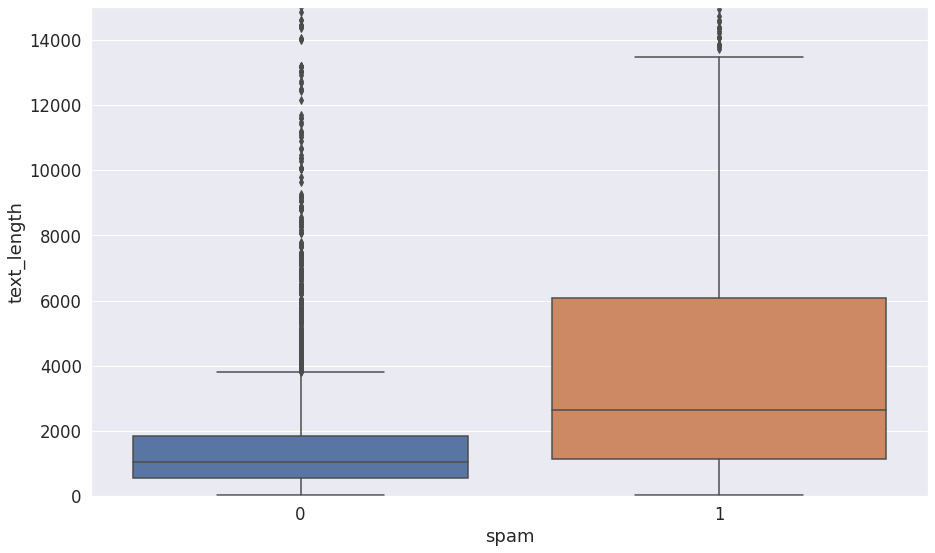

In [129]:
sns.boxplot(x = "spam", y = 'text_length', data = train)
plt.ylim([0,15000])

We find that there are lots of outliers in ham emails, we try to look at them

In [130]:
train

,id,subject,email,spam,text_length,predicted_value,isReply
0,6452,Subject: Re: Ximian apt repos?\n,on 21 jul 2002 14:20:42 +1200\n mark derricutt...,0,2186,0,1
1,1488,"Subject: Re: dylsexics of the wrold, untie!\n","on thu, 12 sep 2002, tom wrote:\n \n > yep, th...",0,567,0,1
2,3693,Subject: Re: [VoID] a new low on the personals...,pity. reading that woman's ad and knowing roh...,0,285,0,1
3,156,Subject: Re: [SAtalk] OT: DNS MX Record Clarif...,"on fri, 2002-09-13 at 14:33, vernon wrote:\n >...",0,875,0,1
4,3353,Subject: 11th Convergence India 2003 exhibitio...,<html><head>\n <meta http-equiv=content-type c...,1,8285,0,0
...,...,...,...,...,...,...,...
6608,5191,Subject: Need a Lawyer?\n,this is a multi-part message in mime format.\n...,1,5472,0,0
6609,5226,"Subject: Home Loan Alert, 6.25 30 YR Fixed hzo\n","<html>\n \n <body>\n \n <font size=""2"" ptsize=...",1,6643,0,0
6610,5390,Subject: Re: Ouch... [Bebergflame]\n,"on fri, 6 sep 2002, kragen sitaker wrote:\n \n...",0,435,0,1
6611,860,Subject: Re: new bugs\n,--==_exmh_-2058972181p\n content-type: text/pl...,0,2279,0,1


We find that there are lots of html format messages, so we may first convert all the html format to normal format

Think of number of ? and !

In [131]:
pattern = r".*(\?|\!){2,10}.*"
train['Number_of_punct_in_subject'] = train['subject'].str.findall(pattern).map(lambda x: len(x))
train['Number_of_punct_in_email'] = train['email'].str.findall(pattern).map(lambda x: len(x))

Upper case in title

In [132]:
# Define the uppercase words to be words with more than 4 upper letters
pattern = r".*[A-Z]{5,20}.*"
train['Number_of_upper'] = train['subject'].str.findall(pattern).map(lambda x: len(x))
train[train['Number_of_upper'] >= 1]['spam'].value_counts()

1    321
0    174
Name: spam, dtype: int64

We fit the model

In [133]:
Y_train = train['spam']
word_features = words_in_texts(['font','we'], train['email'])
other_features = np.array(train[['isReply','Number_of_punct_in_email','Number_of_upper']])
new_X_train = np.hstack((word_features, other_features))


In [134]:
model2 = LogisticRegression(random_state = 0).fit(new_X_train, Y_train)


Do some statistic check

In [135]:
# Get the predicted value
train['predicted_value_2'] = model2.predict(new_X_train)

# Calculate the basic quantaties
TP = len(train[(train['spam'] == 1) & (train['predicted_value_2'] == 1)])
TN = len(train[(train['spam'] == 0) & (train['predicted_value_2'] == 0)])
FP = len(train[(train['spam'] == 0) & (train['predicted_value_2'] == 1)])
FN = len(train[(train['spam'] == 1) & (train['predicted_value_2'] == 0)])
print("Recall is:" , TP/(TP+FN))
print("Acurracy is:", model2.score(new_X_train, Y_train))

Recall is: 0.642271662763466
Acurracy is: 0.8563435657039166


Validation on val set

In [136]:
# add isReply
pattern = r".*(RE:|Re:).*"
val['isReply'] = val['subject'].str.findall(pattern).map(lambda x: 0 if len(x) == 0 else 1)

# add number of punct
pattern = r".*(\?|\!){2,10}.*"
val['Number_of_punct_in_subject'] = val['subject'].str.findall(pattern).map(lambda x: len(x))
val['Number_of_punct_in_email'] = val['email'].str.findall(pattern).map(lambda x: len(x))

# add number of uppercase
pattern = r".*[A-Z]{5,20}.*"
val['Number_of_upper'] = val['subject'].str.findall(pattern).map(lambda x: len(x))

In [137]:
Y_test = val['spam']
test_word_features = words_in_texts(['font','we'], val['email'])
test_other_features = np.array(val[['isReply','Number_of_punct_in_email','Number_of_upper']])
X_test = np.hstack((test_word_features, test_other_features))
val['predicted_value'] = model2.predict(X_test)

# Calculate the basic quantaties
TP = len(val[(val['spam'] == 1) & (val['predicted_value'] == 1)])
TN = len(val[(val['spam'] == 0) & (val['predicted_value'] == 0)])
FP = len(val[(val['spam'] == 0) & (val['predicted_value'] == 1)])
FN = len(val[(val['spam'] == 1) & (val['predicted_value'] == 0)])
print("Recall is:" , TP/(TP+FN))
print("Acurracy is:", model2.score(X_test, Y_test))

Recall is: 0.6625
Acurracy is: 0.8734693877551021


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 9: ROC Curve

In most cases we won't be able to get no false positives and no false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for your final classifier on the training data. Refer to **Lecture 22** to see how to plot an ROC curve.

<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->

<AxesSubplot:title={'center':'ROC Curve for Final Model'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

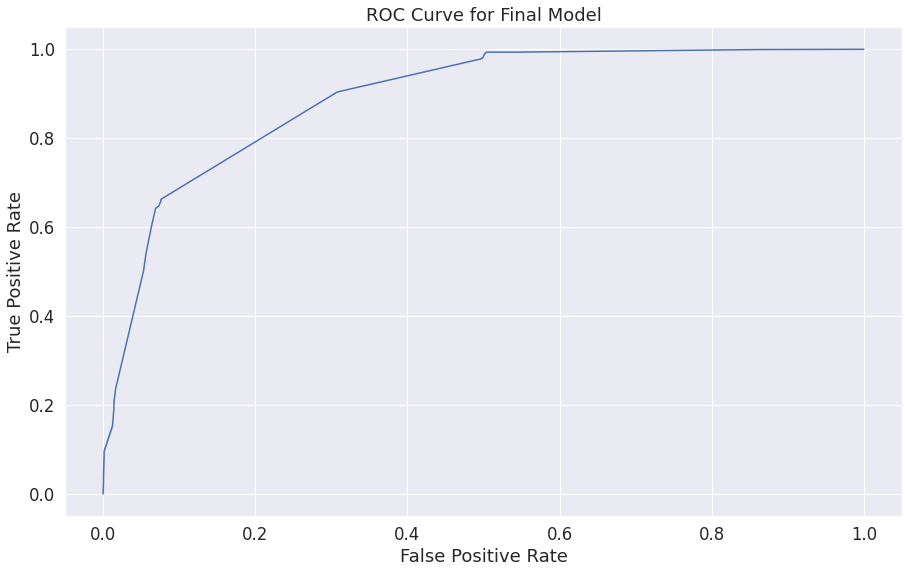

In [138]:
from sklearn.metrics import roc_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

fpr, tpr, threshold = roc_curve(Y_train, model2.predict_proba(new_X_train)[:, 1])
fig = sns.lineplot(x=fpr, y = tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Final Model")
fig

<!-- END QUESTION -->

# Question 10: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions` (contains 0 and 1s). **Please make sure you've saved your predictions to `test_predictions` as this is how part of your score for this question will be determined.**

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.


<!--
BEGIN QUESTION
name: q10
points: 3
-->

In [ ]:
# Print the NaN value in id column
id_nan = test['id'].isnull()
print("The NaN values in id column is: ",len(id_nan[id_nan != False]))

# Print the NaN value in subject column
subject_nan = test['subject'].isnull()
print("The NaN values in subject column is: ",len(subject_nan[subject_nan != False]))

# Print the NaN value in email colunm
email_nan = test['email'].isnull()
print("The NaN values in email column is: ", len(email_nan[email_nan != False]))

# Replace the NaN with empty strings
test.loc[id_nan[id_nan != False].index, 'id'] = ''
test.loc[subject_nan[subject_nan != False].index,'subject'] = ''
test.loc[email_nan[email_nan != False].index, 'email'] = ''

# Print the NaN value in id column
id_nan = test['id'].isnull()
print("The NaN values in id column after replacement is: ",len(id_nan[id_nan != False]))

# Print the NaN value in subject column
subject_nan = test['subject'].isnull()
print("The NaN values in subject column after replacement is: ",len(subject_nan[subject_nan != False]))

# Print the NaN value in email colunm
email_nan = test['email'].isnull()
print("The NaN values in email column after replacement is: ", len(email_nan[email_nan != False]))

In [139]:
# add isReply
pattern = r".*(RE:|Re:).*"
test['isReply'] = test['subject'].str.findall(pattern).map(lambda x: 0 if len(x) == 0 else 1)

# add number of punct
pattern = r".*(\?|\!){2,10}.*"
test['Number_of_punct_in_subject'] = test['subject'].str.findall(pattern).map(lambda x: len(x))
test['Number_of_punct_in_email'] = test['email'].str.findall(pattern).map(lambda x: len(x))

# add number of uppercase
pattern = r".*[A-Z]{5,20}.*"
test['Number_of_upper'] = test['subject'].str.findall(pattern).map(lambda x: len(x))

test_word_features = words_in_texts(['font','we'], test['email'])
test_other_features = np.array(test[['isReply','Number_of_punct_in_email','Number_of_upper']])
X_test = np.hstack((test_word_features, test_other_features))

test_predictions = model2.predict(X_test)

TypeError: object of type 'float' has no len()

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project 2 Test Predictions" assignment on Canvas to get credit for this question.**

In [ ]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Canvas for grading.')

Created a CSV file: submission_2022-04-22T14:36:35.csv.
You may now upload this CSV file to Canvas for grading.


## Submission

Make sure you have run all cells in your notebook in order before     running the cell below, so that all images/graphs appear in the output.  **Please save before exporting!**